# Overview

This notebook helps to create and validate a training set for the k-NN classifier described in the MediaPipe [Pose Classification](https://google.github.io/mediapipe/solutions/pose_classification.html) solution, it has greatly been inspired by it code example. Test it on an arbitrary video, export to a CSV and then use it to develop your own application.

# Step 0: Env setup

In [1]:
# !pip install pillow matplotlib numpy opencv-python tqdm requests mediapipe

In [2]:
#use this if the "Partie 2" folder is not your work directory.
# %cd Partie\ 2

# Codebase

## Commons

In [3]:
from matplotlib import pyplot as plt
import numpy as np

### Comon folder architecture

In [4]:
import shutil
import os
from PoseClassification.utils import (
    show_image,
    create_images_folder_structure,
    create_docs_folder_structure,
    assert_images_in_folder,
    classify_pictures,
    sort_images
)

try:
    sort_images(
        os.getcwd(),
        "docs/images/obj",
    )
except:
    print("Already parsed images")

# classify_pictures()

Already parsed images


In [5]:
# create_images_folder_structure()
# create_docs_folder_structure()
# assert_images_in_folder()

## Pose embedding

In [6]:
from PoseClassification.pose_embedding import FullBodyPoseEmbedding

## Pose classification

In [7]:
from PoseClassification.pose_classifier import PoseClassifier

## Classification smoothing

In [8]:
from PoseClassification.utils import EMADictSmoothing

## Repetition counter

In [9]:
from PoseClassification.utils import RepetitionCounter

## Classification visualizer

In [10]:
from PoseClassification.visualize import PoseClassificationVisualizer

## Bootstrap helper

In [11]:
from PoseClassification.bootstrap import BootstrapHelper

# Step 1: Build classifier

## Image samples

Locally create a folder named `fitness_poses_images_in` with image samples.

Images should repesent terminal states of desired pose classes. I.e. if you want to classify push-up provide iamges for two classes: when person is up, and when person is down.

There should be about a few hundred samples per class covering different camera angles, environment conditions, body shapes, and exercise variations to build a good classifier.

Required structure of the images_in_folder:
```
fitness_poses_images_in/
  pushups_up/
    image_001.jpg
    image_002.jpg
    ...
  pushups_down/
    image_001.jpg
    image_002.jpg
    ...
  ...
```

## Bootstrap images

In [12]:
# Required structure of the images_in_folder:
#
#   fitness_poses_images_in/
#     pushups_up/
#       image_001.jpg
#       image_002.jpg
#       ...
#     pushups_down
# 
# /
#       image_001.jpg
#       image_002.jpg
#       ...
#     ...
cwd = os.getcwd()
bootstrap_images_in_folder = os.path.join(cwd, "fitness_poses_images_in")

# Output folders for bootstrapped images and CSVs.
bootstrap_images_out_folder = os.path.join(cwd, "fitness_poses_images_out")
bootstrap_csvs_out_folder = os.path.join(cwd, "fitness_poses_csvs_out")

In [13]:
# Initialize helper.
bootstrap_helper = BootstrapHelper(
    images_in_folder=bootstrap_images_in_folder,
    images_out_folder=bootstrap_images_out_folder,
    csvs_out_folder=bootstrap_csvs_out_folder,
)

In [14]:
# Check how many pose classes and images for them are available.
bootstrap_helper.print_images_in_statistics()

Number of images per pose class:
  pushups_down: 940
  pushups_up: 1141


In [15]:
# Bootstrap all images.
# Set limit to some small number for debug.
bootstrap_helper.bootstrap(per_pose_class_limit=10)

Bootstrapping  pushups_down
  0%|          | 0/10 [00:00<?, ?it/s]

I0000 00:00:1699885014.823138       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1 Max
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
100%|██████████| 10/10 [00:01<00:00,  6.99it/s]
Bootstrapping  pushups_up
100%|██████████| 10/10 [00:01<00:00,  7.13it/s]


In [16]:
# Check how many images were bootstrapped.
bootstrap_helper.print_images_out_statistics()

Number of images per pose class:
  pushups_down: 10
  pushups_up: 10


In [17]:
# After initial bootstrapping images without detected poses were still saved in
# the folderd (but not in the CSVs) for debug purpose. Let's remove them.
bootstrap_helper.align_images_and_csvs(print_removed_items=False)
bootstrap_helper.print_images_out_statistics()

Number of images per pose class:
  pushups_down: 7
  pushups_up: 10


## Manual filtration

Please manually verify predictions and remove samples (images) that has wrong pose prediction. Check as if you were asked to classify pose just from predicted landmarks. If you can't - remove it.

Align CSVs and image folders once you are done.

In [18]:
# Align CSVs with filtered images.
bootstrap_helper.align_images_and_csvs(print_removed_items=True)
bootstrap_helper.print_images_out_statistics()

Number of images per pose class:
  pushups_down: 7
  pushups_up: 10


## Automatic filtration

Classify each sample against database of all other samples and check if it gets in the same class as annotated after classification.

There can be two reasons for the outliers:

  * **Wrong pose prediction**: In this case remove such outliers.

  * **Wrong classification** (i.e. pose is predicted correctly and you aggree with original pose class assigned to the sample): In this case sample is from the underrepresented group (e.g. unusual angle or just very few samples). Add more similar samples and run bootstrapping from the very beginning.

Even if you just removed some samples it makes sence to re-run automatic filtration one more time as database of poses has changed.

**Important!!** Check that you are using the same parameters when classifying whole videos later.

In [19]:
# Find outliers.

# Transforms pose landmarks into embedding.
pose_embedder = FullBodyPoseEmbedding()

# Classifies give pose against database of poses.
pose_classifier = PoseClassifier(
    pose_samples_folder=bootstrap_csvs_out_folder,
    pose_embedder=pose_embedder,
    top_n_by_max_distance=30,
    top_n_by_mean_distance=10)

outliers = pose_classifier.find_pose_sample_outliers()
print('Number of outliers: ', len(outliers))

Number of outliers:  1


Outlier
  sample path =     /Users/manulabricole/Documents/CDN/ACV/Partie_2/fitness_poses_images_out/pushups_down/pushup%20(1003)_jpg.rf.a1fc872cbcd7a7030d3af186f36fd99e.jpg
  sample class =    pushups_down
  detected class =  ['pushups_down', 'pushups_up']
  all classes =     {'pushups_down': 5, 'pushups_up': 5}


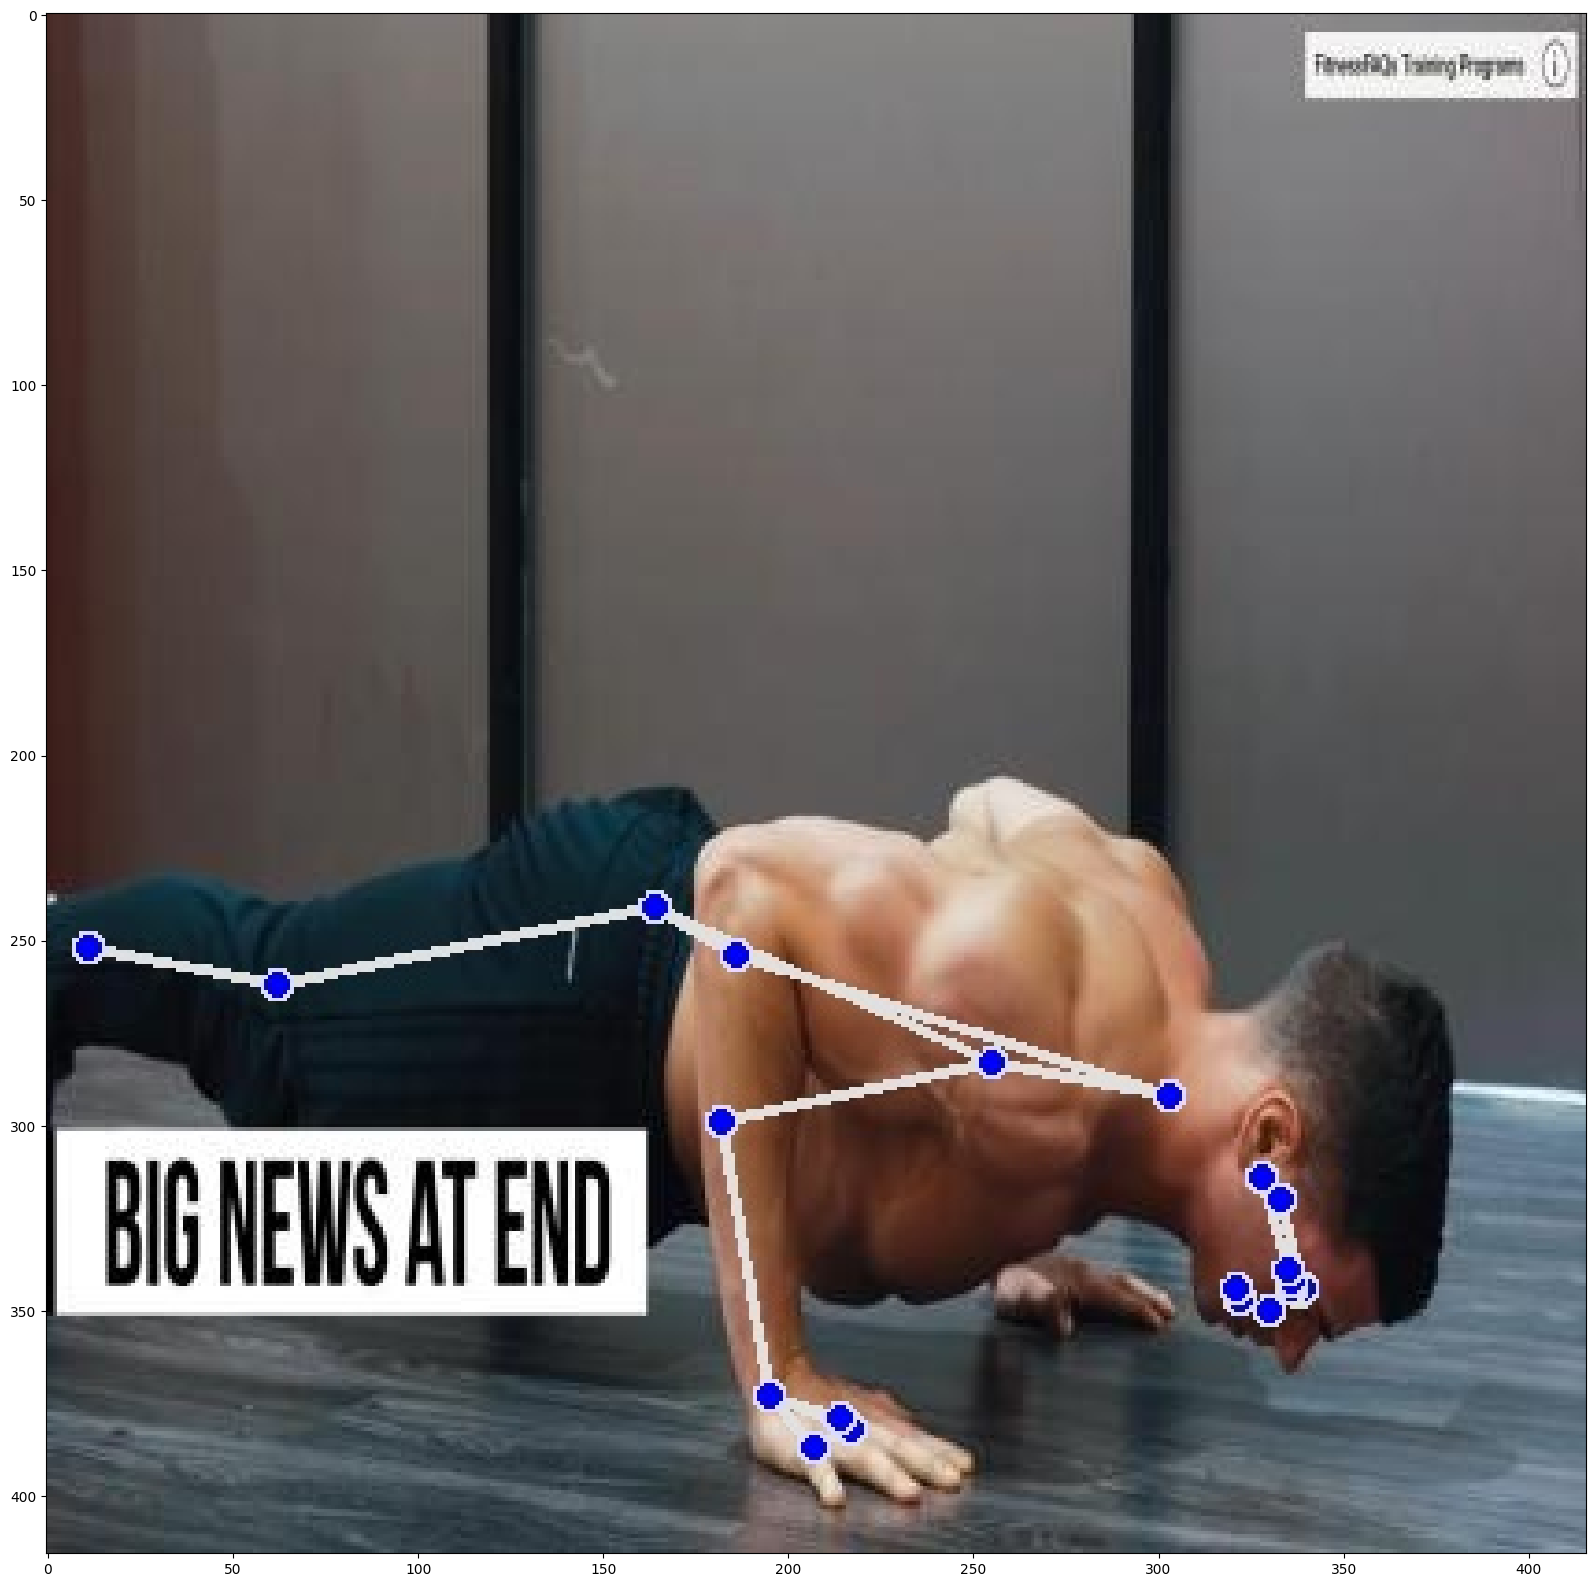

In [20]:
# Analyze outliers.
bootstrap_helper.analyze_outliers(outliers)

In [21]:
# Remove all outliers (if you don't want to manually pick).
bootstrap_helper.remove_outliers(outliers)

In [22]:
# Align CSVs with images after removing outliers.
bootstrap_helper.align_images_and_csvs(print_removed_items=False)
bootstrap_helper.print_images_out_statistics()

Number of images per pose class:
  pushups_down: 6
  pushups_up: 10


## Dump classifier data to CSV

Dump filtered poses to CSV and download it.

*Opt. : Please check this [guide](https://developers.google.com/ml-kit/vision/pose-detection/classifying-poses#4_integrate_with_the_ml_kit_quickstart_app) on how to use this CSV in the ML Kit sample app.*

In [23]:
import csv
import os
import numpy as np


def dump_for_the_app():
    pose_samples_folder = "fitness_poses_csvs_out"
    pose_samples_csv_path = "fitness_poses_csvs_out.csv"
    file_extension = "csv"
    file_separator = ","

    # Each file in the folder represents one pose class.
    file_names = [
        name
        for name in os.listdir(pose_samples_folder)
        if name.endswith(file_extension)
    ]

    with open(pose_samples_csv_path, "w") as csv_out:
        csv_out_writer = csv.writer(
            csv_out, delimiter=file_separator, quoting=csv.QUOTE_MINIMAL
        )
        for file_name in file_names:
            # Use file name as pose class name.
            class_name = file_name[: -(len(file_extension) + 1)]

            # One file line: `sample_00001,x1,y1,x2,y2,....`.
            with open(os.path.join(pose_samples_folder, file_name)) as csv_in:
                csv_in_reader = csv.reader(csv_in, delimiter=file_separator)
                for row in csv_in_reader:
                    row.insert(1, class_name)
                    csv_out_writer.writerow(row)

    # files.download(pose_samples_csv_path)


dump_for_the_app()

# Step 2: Classification

**Important!!** Check that you are using the same classification parameters as while building classifier.

In [34]:
# Specify your video name and target pose class to count the repetitions.
video_folder = os.path.join(cwd, "docs", "videos", "correct_sequence")

for file in os.listdir(video_folder):
    if file.endswith(".mp4"):
        # Replace spaces with underscores in the filename
        new_filename = file.replace(" ", "_")

        if new_filename != file:  # Check if a rename is necessary
            # Define the current and new file paths
            old_video_path = os.path.join(video_folder, file)
            new_video_path = os.path.join(video_folder, new_filename)

            # Rename the file
            os.rename(old_video_path, new_video_path)

files = os.listdir(video_folder)
filepath = os.path.join(video_folder, files[5])

In [35]:
video_path = filepath
print(video_path)
class_name = "pushups_up"
out_video_path = "pushups-sample-out.mp4"

/Users/manulabricole/Documents/CDN/ACV/Partie_2/docs/videos/correct_sequence/Copy_of_push_up_79.mp4


In [36]:
# Open the video.
import cv2

video_cap = cv2.VideoCapture(video_path)

# Get some video parameters to generate output video with classificaiton.
video_n_frames = video_cap.get(cv2.CAP_PROP_FRAME_COUNT)
video_fps = video_cap.get(cv2.CAP_PROP_FPS)
video_width = int(video_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
video_height = int(video_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

print(f"video_n_frames: {video_n_frames}")
print(f"video_fps: {video_fps}")
print(f"video_width: {video_width}")
print(f"video_height: {video_height}")

video_n_frames: 45.0
video_fps: 25.0
video_width: 640
video_height: 360


In [40]:
# Initialize tracker, classifier and counter.
# Do that before every video as all of them have state.
from mediapipe.python.solutions import pose as mp_pose


# Folder with pose class CSVs. That should be the same folder you used while
# building classifier to output CSVs.
pose_samples_folder = 'fitness_poses_csvs_out'

# Initialize tracker.
pose_tracker = mp_pose.Pose()

# Initialize embedder.
pose_embedder = FullBodyPoseEmbedding()

# Initialize classifier.
# Check that you are using the same parameters as during bootstrapping.
pose_classifier = PoseClassifier(
    pose_samples_folder=pose_samples_folder,
    pose_embedder=pose_embedder,
    top_n_by_max_distance=30,
    top_n_by_mean_distance=10)

# # Uncomment to validate target poses used by classifier and find outliers.
outliers = pose_classifier.find_pose_sample_outliers()
print('Number of pose sample outliers (consider removing them): ', len(outliers))

# Initialize EMA smoothing.
pose_classification_filter = EMADictSmoothing(
    window_size=10,
    alpha=0.2)

# Initialize counter.
repetition_counter = RepetitionCounter(
    class_name=class_name,
    enter_threshold=6,
    exit_threshold=4)

# Initialize renderer.
pose_classification_visualizer = PoseClassificationVisualizer(
    class_name=class_name,
    plot_x_max=video_n_frames,
    # Graphic looks nicer if it's the same as `top_n_by_mean_distance`.
    plot_y_max=10)

Number of pose sample outliers (consider removing them):  4


I0000 00:00:1699885327.513790       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1 Max


In [41]:
# Run classification on a video.
import os
import tqdm

from mediapipe.python.solutions import drawing_utils as mp_drawing


# Open output video.
out_video = cv2.VideoWriter(out_video_path, cv2.VideoWriter_fourcc(*'mp4v'), video_fps, (video_width, video_height))

frame_idx = 0
output_frame = None
with tqdm.tqdm(total=video_n_frames, position=0, leave=True) as pbar:
  while True:
    # Get next frame of the video.
    success, input_frame = video_cap.read()
    if not success:
      print("unable to read input video frame, breaking!")
      break

    # Run pose tracker.
    input_frame = cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB)
    result = pose_tracker.process(image=input_frame)
    pose_landmarks = result.pose_landmarks

    # Draw pose prediction.
    output_frame = input_frame.copy()
    if pose_landmarks is not None:
      mp_drawing.draw_landmarks(
          image=output_frame,
          landmark_list=pose_landmarks,
          connections=mp_pose.POSE_CONNECTIONS)
    
    if pose_landmarks is not None:
      # Get landmarks.
      frame_height, frame_width = output_frame.shape[0], output_frame.shape[1]
      pose_landmarks = np.array([[lmk.x * frame_width, lmk.y * frame_height, lmk.z * frame_width]
                                 for lmk in pose_landmarks.landmark], dtype=np.float32)
      assert pose_landmarks.shape == (33, 3), 'Unexpected landmarks shape: {}'.format(pose_landmarks.shape)

      # Classify the pose on the current frame.
      pose_classification = pose_classifier(pose_landmarks)

      # Smooth classification using EMA.
      pose_classification_filtered = pose_classification_filter(pose_classification)

      # Count repetitions.
      repetitions_count = repetition_counter(pose_classification_filtered)
    else:
      # No pose => no classification on current frame.
      pose_classification = None

      # Still add empty classification to the filter to maintaing correct
      # smoothing for future frames.
      pose_classification_filtered = pose_classification_filter(dict())
      pose_classification_filtered = None

      # Don't update the counter presuming that person is 'frozen'. Just
      # take the latest repetitions count.
      repetitions_count = repetition_counter.n_repeats

    # Draw classification plot and repetition counter.
    output_frame = pose_classification_visualizer(
        frame=output_frame,
        pose_classification=pose_classification,
        pose_classification_filtered=pose_classification_filtered,
        repetitions_count=repetitions_count)

    # Save the output frame.
    out_video.write(cv2.cvtColor(np.array(output_frame), cv2.COLOR_RGB2BGR))

    # Show intermediate frames of the video to track progress.
    if frame_idx % 50 == 0:
      show_image(output_frame)

    frame_idx += 1
    pbar.update()

# Close output video.
out_video.release()

# Release MediaPipe resources.
# pose_tracker.close()

# Show the last frame of the video.
if output_frame is not None:
  show_image(output_frame)

  0%|          | 0/45.0 [00:00<?, ?it/s]

unable to read input video frame, breaking!
